# Program a NN 

In this excercise you will create a 1-hidden-layer neural network. It will be used to predict future value of quarterly euro area rGDP (real Gross Domestic Product). You will predict it by using one lag of rGDP and IP (Industrial Production). You will then compare the NN model with a linear regression model (VAR), if time permits.         

In [1]:
## PACKAGES
# pckg for data management
import pandas as pd
# pckg with basic mat functions
import numpy  as np
# pckg for plotting
import matplotlib.pyplot as plt
# pckg for stat modelling
import statsmodels.api as sm
# pckg for manipulating directories
import os

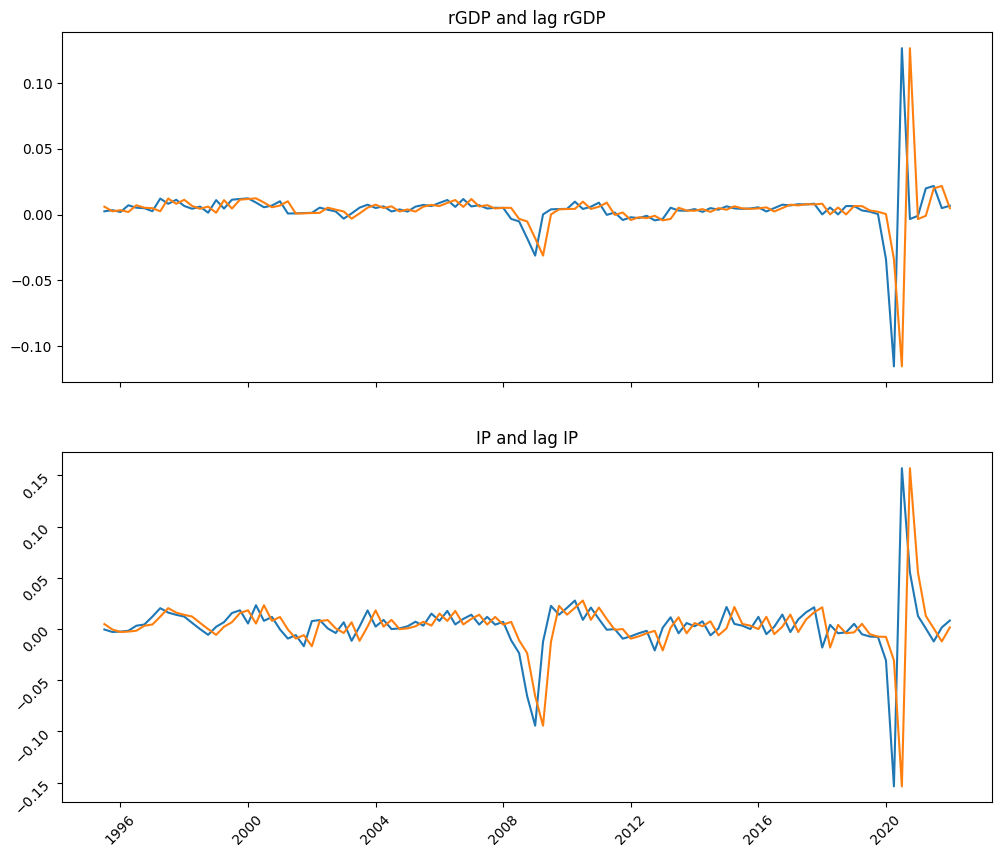

In [2]:
## DATA
# load and organize data
df = pd.read_excel('data_ea.xlsx')                              # import data
df.date = pd.to_datetime(df.date).dt.date                       # transform date from string to datetime type
df.set_index('date',drop=True,inplace=True)                     # declare date as index and drop date column 
df = pd.DataFrame.pct_change(df).dropna()                       # overwrite with growth rates 

# plot
fig, axs = plt.subplots(2,1, sharex=True,figsize=(12,10))
axs[0].plot(df.rgdp);
axs[0].plot(df.Lrgdp);
axs[0].set_title('rGDP and lag rGDP');
axs[1].plot(df.ip);
axs[1].plot(df.Lip);
axs[1].set_title("IP and lag IP");
axs[1].tick_params(labelrotation=45)

In [6]:
# declare data {y,x} as numpy arrays 
y = np.array(df.rgdp)
X = np.array(df[['Lrgdp','ip','Lip']])

## NN graph
See Fig_NN.jpg. 

### Define network arhitecture

Fisrt we define the size of the input layer (number of explanatory variables with constant/bias included), number of hidden layers, their sizes and an output layer (number of variables that you will be predicting). 

In [3]:
# Define network arhitecture
n_hidden = 2                  # size of the hidden layer (excluding bias); experiment! 
n_output = 1                  # size of output layer (we will only predict regdp) 
lam      = 0                  # regularization term (set to zero for now...) 

You will:

- Program a function that (i) returns the value of the cost function ($ J \Theta $). Cost function will implement Forward Propagation algorithm (fit and value of the cost function) 
- Add Backward Propagation algorithm to the cost function and return also the gradient of the cost function ($\frac{\partial J}{\partial \Theta^{(l)}}$). 
- Pass the data and the cost function to a (stochastic) gradient descent algorithm which will minimize it w.r.t. $\Theta$.      
- Solve a difficulty with NN's learning progress.  
- Implement also the regularization (?). 
- Use the NN to predict the value of rGDP (use 80/20 train-test split). 


# STEP 1: Programe the cost function and forward propagation algorithm 
1.1 Implement forward propagation. <br>
We will need to declare "helper" functions to implement forward propagation:
- get_z()       - will calculate "$z=\Theta a$" for a single run (=row/observation) of data 
- sigmoid() - will calculate "$a=h(z)=...$" where h is sigmoid
- ident()   - will calculate "$a=h(z)=z$" [not really needed, for completness or if you wish to modify the last layer activation function]
- loss()    - will calculate "$l=1/2*(y-a^{(L)})^2$"  (cost = sum(loss))


### Code z, call it get_z(), test it
$z = \Theta a$  

In [15]:
# function:  returns "z = Theta*x"
def get_z(theta,a):
    ###### YOUR CODE HERE ###### 
    z = np.matmul(theta, a)
    ###### YOUR CODE HERE ######
    return z
# get_z ends here

In [7]:
#   Before we test z we need to make sure the passed data is of correct dimmensions
#   NOTE: When you slice variables Python can drop dimmensions!
#   Make sure your variables are sliced in a way that does not change them. 


# take a row of data, transpose it, add "bias", make sure its dimmension is (3,1)! 
x_i = X[0,:]     
# note that numpy drops dimmensions when slicing (matrix multiplications will return an error!)
x_i.shape 
print(f"X[0,:] dims:{x_i.shape}                 -> will return an error!")
# to keep the dimmensions you need to either (1) add "None", slice with "index as list", or use "reshape" 
x_i = X[None,0,:]     
print(f"X[None,0,:] dims: {x_i.shape}         -> ok")
x_i = X[[0],:]     
print(f"X[[0],:] dims: {x_i.shape}            -> ok")
x_i = np.reshape(X[0,:],[1,X.shape[1]])
print(f"np.reshape(X,[1,2]) dims: {x_i.shape} -> ok")
print("--------------------------------------------")

# x_i: take the first row of X, add bias (=1) to the beggining and reshape to a (3x1) vector
x_i = X[None,0,:]     
x_i = np.reshape(np.insert(x_i,0,1),[x_i.shape[1]+1,1]) 
print(f"X_i is \n x_i = {x_i}")

# Theta: assume a (1x4) matrix with entries [1,0.5,-0.5,0.5]
theta = np.reshape(np.array([1,0.5,-0.5,0.5]),[1,X.shape[1]+1])
print(f"theta is theta = {theta}")

X[0,:] dims:(3,)                 -> will return an error!
X[None,0,:] dims: (1, 3)         -> ok
X[[0],:] dims: (1, 3)            -> ok
np.reshape(X,[1,2]) dims: (1, 3) -> ok
--------------------------------------------
X_i is 
 x_i = [[ 1.00000000e+00]
 [ 5.94626186e-03]
 [-4.05515055e-04]
 [ 4.88997556e-03]]
theta is theta = [[ 1.   0.5 -0.5  0.5]]


In [8]:
### test get_z() 
# call get_z(theta,xi) and display returned value
z = get_z(theta,x_i)
print(f"Returned z should be 1.00052814 and is {z}")

Returned z should be 1.00052814 and is [[1.00562088]]


### Code sigmoid function, call it get_sigmoid(), test it
Sigmoid function: $y(z) = \frac{1}{1+e^{-z}}$ 

In [9]:
# function: get_sigmoid "a = sigmoid(z)"
def sigmoid(z):
    ###### YOUR CODE HERE ######
    a = 1/(1 + np.exp(-z))
    ###### YOUR CODE HERE ######
    return a
# sigmoid() ends here

In [10]:
### test sigmoid() 
# call sigmoid(z) and display returned value
a = sigmoid(z)
print(f"Returned a should be 0.73116241 and is {a}")

Returned a should be 0.73116241 and is [[0.73216227]]


### Code identity function, call it ident(), test it (just for completness...)
$a = h(z) = z$

In [11]:
# function:  ident "a =  z"
def ident(z):
    ###### YOUR CODE HERE ######
    a  = z
    ###### YOUR CODE HERE ######
    return a
# ident ends here

In [12]:
### test ident() 
# call ident(z) and display returned value (when y is unbounded the last squishing function is simply an identity function)
a = ident(z)
print(f"Returned a should be 1.00052814 and is {a}")

Returned a should be 1.00052814 and is [[1.00562088]]


In [13]:
# function:  loss "l =  1/2*(y-a^L)^2"
def loss(y,a):
    ###### YOUR CODE HERE ######
    l  = 1/2*(y-a)**2
    ###### YOUR CODE HERE ######
    return l
# loss ends here

In [14]:
### test loss() 
# call loss(y,a) and display returned value
y_test = np.array([3])
a_test = np.array([1])
l = loss(y_test,a_test)
print(f"Returned l should be 2.0 and is {l}")

Returned l should be 2.0 and is [2.]


### Code forward propagation algorithm with cost function, name it cost_func(), test it
This algorithm will return the value of the cost function and fitted values. 

In [33]:
# function:  ident "cost_func = J(Theta)"
def cost_func(theta,y,X,n_hidden,n_output,lam):
    
    # constants and miscelaneous
    m,n_input = X.shape                    # number of training examples and number of inputs
    bias      = np.ones((1,1))             # bias term, numpy array [1]

    # reshape params = vec([theta1,theta2]) into weight matrices 
    theta1 = np.reshape(theta[0:(n_hidden)*(n_input+1)],(n_hidden,(n_input+1)),order='F')
    theta2 = np.reshape(theta[(n_hidden)*(n_input+1):],(n_output,(n_hidden+1)),order='F')
    
    # initialize returned objects - FEEDFORWARD PART
    J  = 0                                        # cost (J) = sum(losses) 
    A3 = np.empty(y.shape)                        # here we will store fit from the final layer
    A3[:] = np.NaN

    for i in range(1,m+1):
        
        # FEEDFORWARD
        ###### YOUR CODE HERE ######
        x_i   = X[None,i-1,:]                   # input 
        a1_   = x_i.transpose()                              # a1 without bias (input layer) nx1
        a1    = np.append(bias, a1_)                              # a1 with bias (make sure that dims are n+1x1
        z1    = get_z(theta1, a1)                              # fit in hidden layer 
        a2_   = sigmoid(z1)                              # a2 without bias term
        a2    = np.append(bias, a2_)                              # output in hidden layer (no bias)
        z2  = get_z(theta2, a2)                                # fit in output layer  
        a3  = ident(z2)                                # output in output layer (identity function since y is unbounded)
       ###### YOUR CODE HERE ######

        # CALCULATE LOSS
        y_i = y[i-1]                            # target or current observation
        ###### YOUR CODE HERE ######
        l   = loss(y_i, a3)                      # loss
        ###### YOUR CODE HERE ######

        # ACCUMULATE LOSS
        J   = J + l

        # SAVE FIT
        A3[i-1] = a3
    
    ###### YOUR CODE HERE ######
    J = (1/m)*J
    ###### YOUR CODE HERE ######
    return J,A3 
        




In [34]:
### test cost_func() 
# call cost_func() and display returned values (J(),a3)

# get random thetas (we will use seed function to make sure we all have the same random thetas)
np.random.seed(0)
n_input = np.shape(X)[1]
theta1 = 0.1*np.random.rand(n_hidden,n_input+1)   # random theta1: n_hidden units (excluding bias) x (n_inputs + 1 for bias)
theta2 = 0.1*np.random.rand(n_output,n_hidden+1)  # random theta2 (we add 1 for the bias term) 

# transform thetas into a vector (this is needed because optimizers only accept parameters as vectors)
theta1_vec = np.reshape(theta1,(n_hidden*(n_input+1),1),order='F')   # vectorize column-wise (theta1.flatten('F'))
theta2_vec = np.reshape(theta2,(n_output*(n_hidden+1),1),order='F')  # vectorize column-wise 
theta_vec  = np.vstack([theta1_vec,theta2_vec])                  # stack vectorized thetas column-wise ((n_hidden*n_input+n_output*n_hidden)x1)
theta_vec  = 0.1*np.reshape(np.sin(np.arange(0,theta_vec.size)),(theta_vec.size,1))
# call cost_func() and display returned values
J,a3 = cost_func(theta_vec,y,X,n_hidden,n_output,lam)
print(f"Returned J should be 0.00260412 and is {J}")


Returned J should be 0.00260412 and is [0.00398392]


C:\Users\Ant\AppData\Local\Temp\ipykernel_10976\55357785.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A3[i-1] = a3


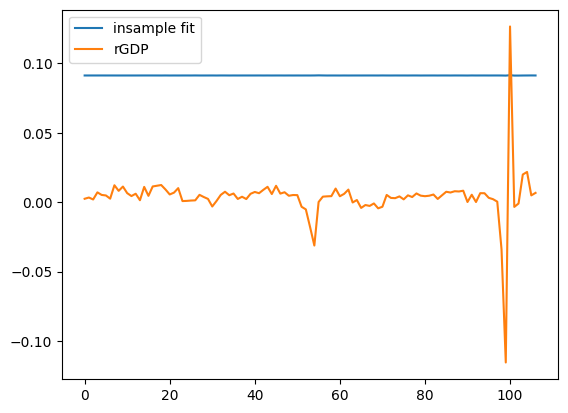

In [35]:
# Plot fit at supplied theta (small random starting values)
plt.plot(a3,label='insample fit')
plt.plot(y,label='rGDP')
plt.legend()

# STEP 2: Add back propagation algorithm and return the gradient 
Implement back propagation algorithm. <br>
We will need to declare "helper" functions to implement back propagation:
- d_sigmoid()       - will derivative of the sigmoid function  
- d_ident()         - will calculate derivative of the identity function (not really needed)
- d_loss()          - will calculate derivative of the loss function

### Code derivative of sigmoid function, name it d_sigmoid(), test it 
Sigmoid function: $a = sigmoid(z) = \frac{1}{1+e^{-z}}$ <br/>
Derivative: $\frac{da}{dz} = a \times (1-a)$

In [38]:
# function:  dsigmoid = "derivative of sigmoid" 
def d_sigmoid(a):
    
    # calculate derivative of sigmoid 
    ###### YOUR CODE HERE ######
    dsig  = np.multiply(a, 1-a)                       # element-by-element multiplication
    ###### YOUR CODE HERE ######
    return dsig
# dsigmoid ends here

In [39]:
### test dsigmoid() 
# call dsigmoid(z) and display returned value
a     = 1.5
d_sig = d_sigmoid(a)
print(f"Returned a should be -0.75 and is {d_sig}")

Returned a should be -0.75 and is -0.75


### Code derivative of the identity function, name it d_ident(), test it (just for completness...)
Sigmoid function: $a = h(z) = z$ <br/>
Derivative: $\frac{da}{dz} = 1$ 

In [49]:
# function:  dident = "derivative of identity function"
def d_ident(a):
    
    # calculate derivative of identity function 
    ###### YOUR CODE HERE ######
    did  = np.ones(a.shape)
    ###### YOUR CODE HERE ######
    return did
# dident ends here

In [50]:
### test d_ident() 
# call d_ident and display returned value
d_id = d_ident(a3[0])
print(f"Returned a should be 1.0 and is {d_id}")

Returned a should be 1.0 and is 1.0


### Code derivative of loss function w.r.t. $a^{(3)}$, name it d_loss, test it
MSE loss: l = $\frac{1}{2}(y-a^{(3)})^2$

In [47]:
# function:  d_loss = "derivative of loss function w.r.t. a3"
def d_loss(y,a):
    
    # calculate derivative of loss function 
    ###### YOUR CODE HERE ######
    dloss  = a - y
    ###### YOUR CODE HERE ######   
    return dloss
# dident ends here

In [48]:
### test d_loss() 
# call d_loss and display returned value
y_i = y[0]
a_i = a3[0]
dloss = d_loss(y_i,a_i)
print(f"Returned a should be  0.08878000518108664 and is {dloss}")

Returned a should be  0.08878000518108664 and is 0.08878000518108664


### Back propagation
Now you are ready to code the back propagation algorithm. Update the cost_func() with appropriate back propagation steps. 

In [52]:
# function:  ident "cost_func = J(Theta)" 
def cost_func(theta,y,X,n_hidden,n_output,lam):
    
    # constants and miscelaneous
    m,n_input = X.shape                          # number of training examples and number of inputs
    bias          = np.ones((1,1))               # bias, numpy array [1]
    dz_dbias      = np.ones((1,1))               # derivative of z w.r.t. bias, numpy array [1]
    
    # reshape params = vec([theta1,theta2]) into weight matrices 
    theta1 = np.reshape(theta[0:(n_hidden)*(n_input+1)],(n_hidden,(n_input+1)),order='F')
    theta2 = np.reshape(theta[(n_hidden)*(n_input+1):],(n_output,(n_hidden+1)),order='F')
    # in backpropagation use these weights (they exclude the "coefficient" for the bias unit)
    th1    = theta1[:,1:] 
    th2    = theta2[:,1:] 
    
    # initialize returned objects - FEEDFORWARD PART
    J  = 0                                        # cost accumulator (J) = sum(losses) 
    A3 = np.empty(y.shape)                        # here we will store fit from the final layer
    A3[:] = np.NaN

    # initialize returned objects - BACK PROPAGATION PART
    D1          = np.zeros(theta1.shape)          #  partial derivatives w.r.t. theta1 accumulator [col bias,col w_a1,col w_a2,..]
    D2          = np.zeros(theta2.shape)          #  partial derivatives w.r.t. theta2 accumulator [bias, w_a1,w_a2,...]

    for i in range(1,m+1):
        
        # FEEDFORWARD
        x_i   = X[None,i-1,:]                   # input 
        a1   = x_i.transpose()                  # a1 without bias (input layer)
        a1b   = np.vstack((bias,a1))            # a1 with bias (make sure that dims are 3x1)
        z1    = get_z(theta1,a1b)               # fit in hidden layer 
        a2    = sigmoid(z1)                     # a2 without bias term
        a2b   = np.vstack((bias,a2))            # a2 with bias term
        z2  = get_z(theta2,a2b)                 # fit in output layer  
        a3  = ident(z2)                         # output in output layer (identity function since y is unbounded)
       
        # CALCULATE LOSS
        y_i = y[i-1]                            # target or current observation
        l   = loss(y_i,a3)                      # loss
        
        # ACCUMULATE LOSS
        J   = J + l

        # SAVE FIT
        A3[i-1] = a3

        # BACK PROPAGATION
        ###### YOUR CODE HERE ######
        # for theta2
        d2          = d_loss(y_i, a3)*d_ident(a3)                                                 # "error" in the output layer
        dz2_dtheta2 = a2                                                 # derivative of z2 w.r.t. theta2
        D2_bias     = d2                                                 # "partial" gradient for bias in last layer 
        D2_weights  = d2*a2.transpose()                                                 # "partial" gradient for weights in last layer   
        D2          = D2 + np.hstack((D2_bias,D2_weights))               # gradient accumulator ([thtea2_0,theta2_1...])
        # for theta1
        d1          = (th2.transpose()@d2)*d_sigmoid(a2)                                                 # "error" in the hidden layer
        dz1_dtheta1 = a1.transpose()                                                 # derivative of z2 w.r.t. theta2
        D1_bias     = d1                                                 # partial gradient for bias
        D1_weights  = d1*dz1_dtheta1                                                 # partial gradient for weights
        D1          = D1 + np.hstack((D1_bias,D1_weights))                # gradient accumulator
        ###### YOUR CODE HERE ######

    # output cost, fit and gradients
    grad_theta1 = (1/m)*D1
    grad_theta2 = (1/m)*D2
    grad = np.hstack((grad_theta1.flatten('F'),grad_theta2.flatten('F')))
    grad = grad[:,np.newaxis]            # not really needed, for sake of keeping complete matrices
    J    = (1/m)*J
    return J,A3,grad 

In [53]:
# Now calculate the gradient
J,A3,grad=cost_func(theta_vec,y,X,n_hidden,n_output,lam)

C:\Users\Ant\AppData\Local\Temp\ipykernel_10976\1742678264.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A3[i-1] = a3


### Test the gradient by comparing it to numerical gradient
Before we continue we need to verify if our back propagartion algorithm works as intended. You need to code a function which calculates numerical gradient and then compare it to back-propagation's gradient. To do this you will first have to declare a "partial cost function." Partial cost function is a function in which some of the inputs to the cost function are pre-filled (with y,x,...; ) so that you can call the cost function without having to supply these arguments. This will also come handy for estimation. During estimation all inputs to the cost function, except thetas, are fixed.    

In [54]:
# import function tools to be used to declare a partial function
import functools as fnct 

# declare a partial cost function
# a partial functions is a function with some of the inputs pre-fixed to specific values 
# we pre-fix all the inputs except nn coefficients. nn coefficients will be perturbed to estimate the numerical gradient
cost_func_partial = fnct.partial(cost_func,y = y, X = X, n_hidden = n_hidden, n_output = n_output, lam = lam)
    

Now we can code numerical gradient. Numerical gradient is simply gradient evaluated by: </br>
$ J(\theta + \epsilon) - J(\theta - \epsilon)/2*\epsilon$ 


In [57]:
# Define numerical gradient
def num_gradient(theta):
    num_grad = np.zeros(theta.shape)    # placeholder for numerical gradient
    eps      = np.zeros(theta.shape)    # placeholder for theta perturbation 
    
    # calculate numerical gradient
    for i in range(0,theta.size):
        # perturb a single parameter at a time and evaluate the cost function
        eps[i] = 1e-4
        ###### YOUR CODE HERE ######
        theta_plus  = theta+eps
        theta_minus = theta-eps
        ###### YOUR CODE HERE ######
        out_plus  = cost_func_partial(theta= theta_plus)
        out_minus = cost_func_partial(theta= theta_minus)
        num_grad[i] = (out_plus[0] - out_minus[0])/(2*eps[i])
        eps[i] = 0
    
    return num_grad


C:\Users\Ant\AppData\Local\Temp\ipykernel_10976\1742678264.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A3[i-1] = a3


Back-propagation gradient (left column) should be very similar to numerical gradient (right column):
[[ 9.00867630e-04  9.00867631e-04]
 [-1.18707014e-03 -1.18707014e-03]
 [ 4.22397777e-06  4.22397777e-06]
 [-5.56657201e-06 -5.56657201e-06]
 [-2.02184015e-06 -2.02184015e-06]]
The norm of the difference between the two solutions should be less than 1e-9:
5.588689791337603e-12


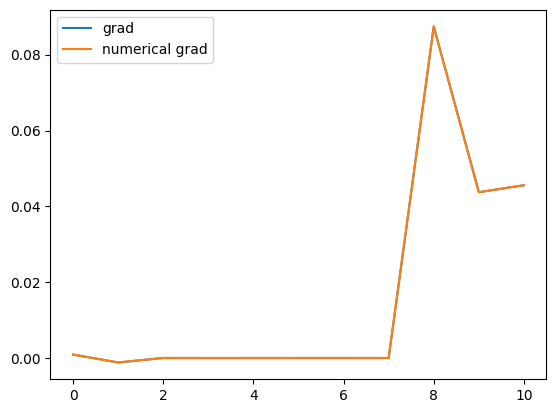

In [58]:
# evaluate numerical gradient and compare it to back-propagation's gradient

# evaluate numerical gradients
num_grad = num_gradient(theta_vec)

# Compare analytical and numerical gradient
print("Back-propagation gradient (left column) should be very similar to numerical gradient (right column):")
print(np.column_stack((num_grad[0:5],grad[0:5])))
print("The norm of the difference between the two solutions should be less than 1e-9:")
print(np.linalg.norm(num_grad-grad)/np.linalg.norm(num_grad+grad))

# Compare gradients visualy
plt.plot(grad,label='grad')
plt.plot(num_grad, label='numerical grad')
plt.legend()



### Network "learning"
Here you will have to train the neural network (minimize cost function w.r.t. parameters). Code the following functions:
- gradDescent() - this function will perform gradient descent 

In [59]:
# Code gradient descent
def gradDescent(theta_vec,y,X,n_hidden,n_output,lam,alpha,iterations):

    # We will be pushing different data to gradDescent so let's declare partial function with current data
    cost_func_partial = fnct.partial(cost_func,y = y, X = X, n_hidden = n_hidden, n_output = n_output, lam = lam)

    
    # initialize storage matrices
    JJ = []                 # storage list for costs
    Thetas_vec = []         # storage list for thetas
    
    # initialize theta
    theta_vec_i = theta_vec
    for i in range(iterations):
         
        # estimate cost and grad at iteration i
        J_i,A3_i,grad_i = cost_func_partial(theta= theta_vec_i)
                
        # store iteration i value of the cost function and theta
        JJ.append(J_i)
        
        # gradient descent step an add next iterations theta 
        ###### YOUR CODE HERE ######
        theta_vec_i = theta_vec_i - alpha*grad_i
        ###### YOUR CODE HERE ######
        Thetas_vec.append(theta_vec_i)
    
    # theta_vec from list to numpy array
    Thetas_vec = np.concatenate(Thetas_vec,axis=1)
    return JJ,Thetas_vec
# gradDeascent() ends here

C:\Users\Ant\AppData\Local\Temp\ipykernel_10976\1742678264.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A3[i-1] = a3


Text(0.5, 1.0, 'Example: Theta(1)_42 over iterations')

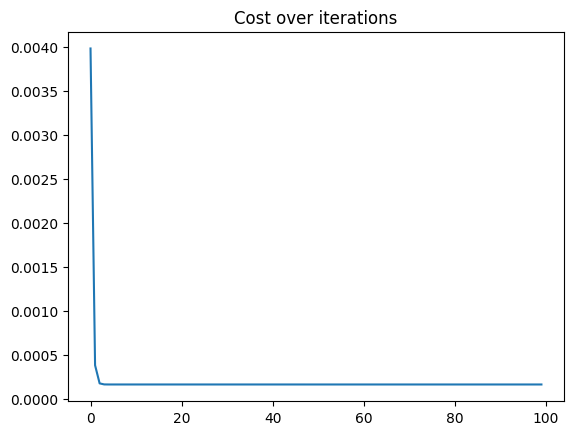

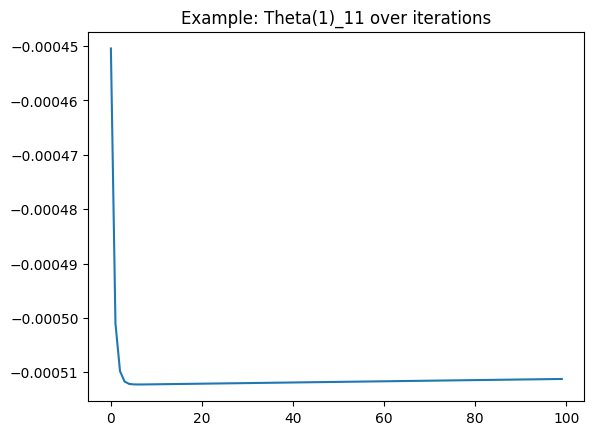

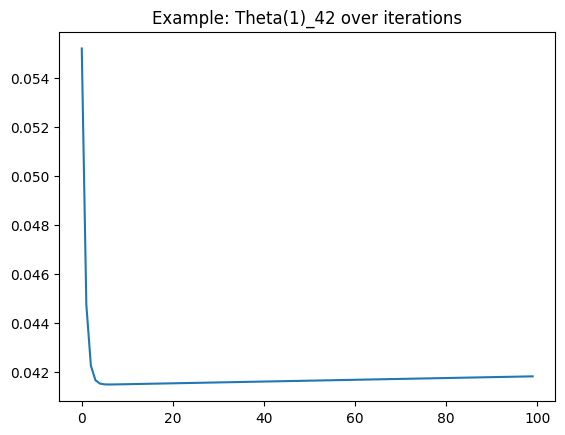

In [63]:
# Test gradient descent
# Call gradient descent and plot results
alpha      = 0.5
iterations = 100
JJ,Thetas_vec  = gradDescent(theta_vec,y,X,n_hidden,n_output,lam,alpha,iterations)

# Plot cost w.r.t. iterations
plt.figure(0)
plt.plot(np.arange(0,iterations),np.asarray(JJ).squeeze())
plt.title('Cost over iterations')

# Plot element (1,1) of theta(1) w.r.t. iterations
plt.figure(1)
plt.plot(np.arange(0,iterations),Thetas_vec[0,:])
plt.title('Example: Theta(1)_11 over iterations')

# Plot element (1,1) of theta(1) w.r.t. iterations
plt.figure(2)
plt.plot(np.arange(0,iterations),Thetas_vec[8,:])
plt.title('Example: Theta(1)_42 over iterations')


In [61]:
# retrieve the estimated theta
theta_vec_est = Thetas_vec[None,:,iterations-1].transpose()
theta1_est = np.reshape(theta_vec_est[0:(n_hidden)*(n_input+1)],(n_hidden,(n_input+1)),order='F')
theta2_est = np.reshape(theta_vec_est[(n_hidden)*(n_input+1):],(n_output,(n_hidden+1)),order='F')

# compare it to initial value for theta
# difference in thetas
print(theta1-theta1_est)
print(theta2-theta2_est)

[[ 0.05527491 -0.01940767  0.13594897  0.08243297]
 [-0.04276657  0.05046553  0.13969131  0.02346579]]
[[0.05483177 0.02587673 0.16354877]]


C:\Users\Ant\AppData\Local\Temp\ipykernel_10976\1742678264.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A3[i-1] = a3


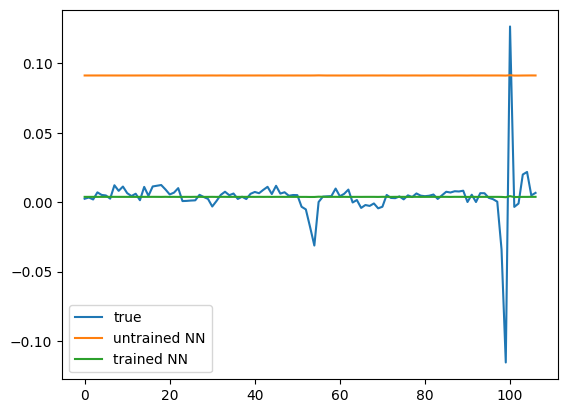

In [64]:
# Plot the fit
A3_untrained   = cost_func(theta_vec,y,X,n_hidden,n_output,lam)[1]
A3_trained     = cost_func(theta_vec_est,y,X,n_hidden,n_output,lam)[1]

plt.plot(y,label='true')
plt.plot(A3_untrained,label='untrained NN')
plt.plot(A3_trained,label='trained NN')
plt.legend()


Fit is poor. What can we do about it? 
Go back and try to increase the learning rate alpha. Does it help? What do you notice from the fitted values? What seems to be happening?   

If you look at the figure which displays the two thetas over iterations you will notice that one converges fast whereas the other one learns very slowly. For this reason we will next implement a gradient descent algorithm which allows for different learning rates per parameter.. 

## AdaGrad

Implementing Relu did not help at all. But, we noticed that some thetas learn fast and some learn slow. In such instances it is good to implement gradient descent algorithm which includes individual learning rates for parameters which learn slow and those which learn fast. You will next implement AdaGrad.   

In [65]:
# Code gradient descent
def gradDescent_ada(theta_vec,y,X,n_hidden,n_output,lam,alpha,iterations,G = None):
    
    # initialize storage matrices
    JJ = []                 # storage list for costs
    Thetas_vec = []         # storage list for thetas
    
    # Accumulator for outer product for all previous gradients
    if G is None:
        G = np.zeros((theta_vec.shape))
    
    eps = 1e-6
    eye = np.identity(theta_vec.size)

    # initialize theta
    theta_vec_i = theta_vec
    for i in range(iterations):
         
        # estimate cost and grad at iteration i
        J_i,A3_i,grad_i = cost_func_partial(theta= theta_vec_i)
                
        # store iteration i value of the cost function and theta
        JJ.append(J_i)
        
        # Store outer product for all previous gradients
        ###### YOUR CODE HERE ######
        G = G+grad_i**2
        inv_sqr_G = 1/np.sqrt(G+eps)
        ###### YOUR CODE HERE ######

        # gradient descent step an add next iterations theta, adaGrad update
        ###### YOUR CODE HERE ######
        step_size = alpha*inv_sqr_G
        theta_vec_i = theta_vec_i-(step_size*grad_i)
        ###### YOUR CODE HERE ######
        Thetas_vec.append(theta_vec_i)
    
    # theta_vec from list to numpy array
    Thetas_vec = np.concatenate(Thetas_vec,axis=1)
    return JJ,Thetas_vec,G
# gradDeascent() ends here

C:\Users\Ant\AppData\Local\Temp\ipykernel_10976\1742678264.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A3[i-1] = a3


Text(0.5, 1.0, 'Example: Theta(1)_42 over iterations')

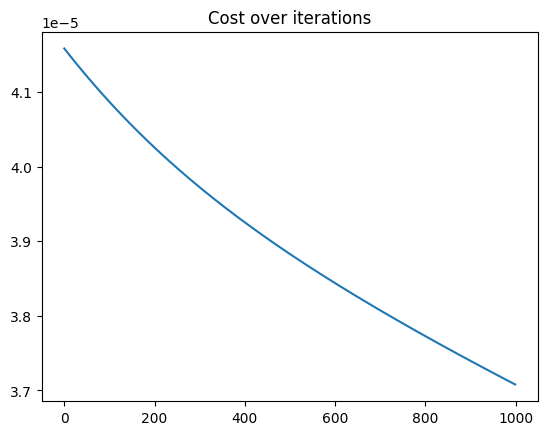

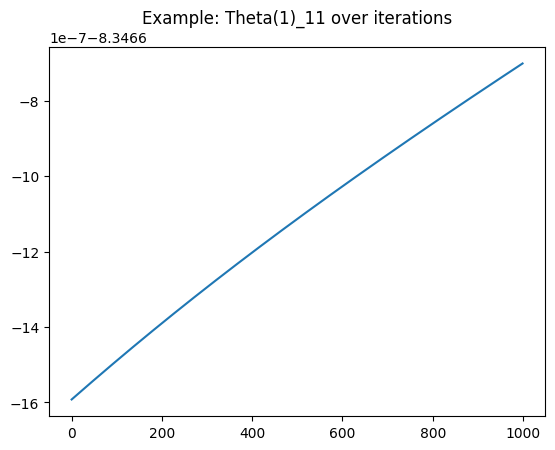

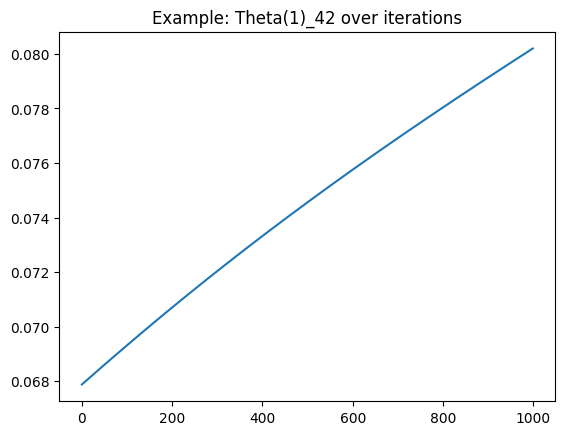

In [66]:
# Test gradient descent
# Call gradient descent and plot results
alpha      = 5       # previous "trail&error" showed that we need to increase step size substantionaly.. 
iterations = 3000    # we also need to increase iterations

JJ,Thetas_vec,G  = gradDescent_ada(theta_vec,y,X,n_hidden,n_output,lam,alpha,iterations)

# Plot cost w.r.t. iterations
n_points = 1000
plt.figure(0)
JJ_ = np.asarray(JJ).squeeze()
plt.plot(np.arange(0,n_points),JJ_[-n_points:])
plt.title('Cost over iterations')

# Plot element (1,1) of theta(1) w.r.t. iterations
plt.figure(1)
plt.plot(np.arange(0,n_points),Thetas_vec[0,-n_points:])
plt.title('Example: Theta(1)_11 over iterations')

# Plot element (1,1) of theta(1) w.r.t. iterations
plt.figure(2)
plt.plot(np.arange(0,n_points),Thetas_vec[8,-n_points:])
plt.title('Example: Theta(1)_42 over iterations')



C:\Users\Ant\AppData\Local\Temp\ipykernel_10976\1742678264.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A3[i-1] = a3


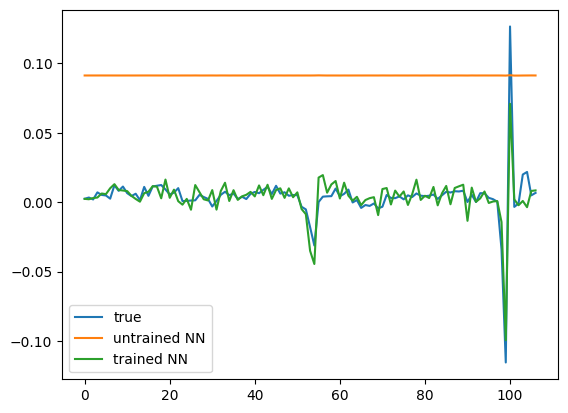

In [67]:
# retrieve the estimated theta
theta_vec_est = Thetas_vec[None,:,iterations-1].transpose()
# Plot the fit
A3_untrained   = cost_func(theta_vec,y,X,n_hidden,n_output,lam)[1]
A3_trained     = cost_func(theta_vec_est,y,X,n_hidden,n_output,lam)[1]

plt.plot(y,label='true')
plt.plot(A3_untrained,label='untrained NN')
plt.plot(A3_trained,label='trained NN')
plt.legend()

### Train NN on training sample and test it on test sample
Here you will have to split the sample to train and test sample (use 80-20% sample split). Next, evaluate cost functions for both samples and plot the two curves.    

In [ ]:
# Get train and test samples
n_train = np.floor(0.8*y.size).astype(int)
y_train = y[0:n_train]
X_train = X[0:n_train,:]
y_test  = y[n_train:]
X_test  = X[n_train:,:]

# Take 1 gradient descent step at a time and store quantities of interest
alpha       = 5
iterations  = 2000
theta_vec_i = theta_vec
J_train     = []
J_test      = []
thetas_vec  = []
G           = None
for i in range(iterations):
    
    ###### YOUR CODE HERE ######
    J_train_i,theta_vec_train_i,G   = gradDescent_ada( , ,  , , , , , , )
    J_test_i,A3_test_i,grad_test_i = cost_func( , , , , , )
    ###### YOUR CODE HERE ######

    J_train.append(J_train_i)
    J_test.append(J_test_i)
    thetas_vec.append(theta_vec_i)
    # update theta
    theta_vec_i = theta_vec_train_i

    

# From list to numpy array
J_train = np.concatenate(J_train,axis = 0).squeeze()
J_test  = np.concatenate(J_test ,axis = 0).squeeze()
thetas_vec = np.concatenate(thetas_vec,axis=1)

# Plot train and test mse w.r.t. iterations (total)
n_points = 1900
plt.plot(np.arange(0,n_points),J_train[-n_points:],label='train mse')
plt.plot(np.arange(0,n_points),J_test[-n_points:], label='test mse')
plt.legend()
plt.title('MSE over iterations')


In [605]:
theta_vec_est = thetas_vec[None,:,iterations-1].transpose()
theta1_est = np.reshape(theta_vec_est[0:(n_hidden)*(n_input+1)],(n_hidden,(n_input+1)),order='F')
theta2_est = np.reshape(theta_vec_est[(n_hidden)*(n_input+1):],(n_output,(n_hidden+1)),order='F')


In [ ]:
# difference in thetas
print(theta1-theta1_est)
print(theta2-theta2_est)
# seems like we can reduce the first layer size
# Now we have a decent difference in thetas!


In [ ]:
# Plot the fit
A3_untrained   = cost_func(theta_vec,y,X,n_hidden,n_output,lam)[1]
A3_trained     = cost_func(theta_vec_est,y,X,n_hidden,n_output,lam)[1]

plt.plot(y,label='true')
plt.plot(A3_untrained,label='untrained NN')
plt.plot(A3_trained,label='trained NN')
plt.legend()




### Now we could add regularization

Regularization helps with overfitting, which might be the case with our network above. 

In [608]:
# function:  ident "cost_func = J(Theta)" 
def cost_func_reg(theta,y,X,n_hidden,n_output,lam):
    
    # constants and miscelaneous
    m,n_input = X.shape                          # number of training examples and number of inputs
    bias          = np.ones((1,1))               # bias, numpy array [1]
    dz_dbias      = np.ones((1,1))               # derivative of z w.r.t. bias, numpy array [1]
    
    # reshape params = vec([theta1,theta2]) into weight matrices 
    theta1 = np.reshape(theta[0:(n_hidden)*(n_input+1)],(n_hidden,(n_input+1)),order='F')
    theta2 = np.reshape(theta[(n_hidden)*(n_input+1):],(n_output,(n_hidden+1)),order='F')
    # in backpropagation use these weights (they exclude the "coefficient" for the bias unit)
    th1    = theta1[:,1:] 
    th2    = theta2[:,1:] 
    
    # initialize returned objects - FEEDFORWARD PART
    J  = 0                                        # cost accumulator (J) = sum(losses) 
    A3 = np.empty(y.shape)                        # here we will store fit from the final layer
    A3[:] = np.NaN

    # initialize returned objects - BACK PROPAGATION PART
    D1          = np.zeros(theta1.shape)          #  partial derivatives w.r.t. theta1 accumulator [col bias,col w_a1,col w_a2,..]
    D2          = np.zeros(theta2.shape)          #  partial derivatives w.r.t. theta2 accumulator [bias, w_a1,w_a2,...]

    for i in range(1,m+1):
        
        # FEEDFORWARD
        x_i   = X[None,i-1,:]                   # input 
        a1   = x_i.transpose()                  # a1 without bias (input layer)
        a1b   = np.vstack((bias,a1))            # a1 with bias (make sure that dims are 3x1)
        z1    = get_z(theta1,a1b)               # fit in hidden layer 
        a2    = sigmoid(z1)                     # a2 without bias term
        a2b   = np.vstack((bias,a2))            # a2 with bias term
        z2  = get_z(theta2,a2b)                 # fit in output layer  
        a3  = ident(z2)                         # output in output layer (identity function since y is unbounded)
       
        # CALCULATE LOSS
        y_i = y[i-1]                            # target or current observation
        l   = loss(y_i,a3)                      # loss
        
        # ACCUMULATE LOSS
        J   = J + l

        # SAVE FIT
        A3[i-1] = a3

        # BACK PROPAGATION
        # for theta2
        d2          = d_loss(y_i,a3)*d_ident(a3)                         # "error" in the output layer
        dz2_dtheta2 = a2                                                 # derivative of z2 w.r.t. theta2
        D2_bias     = d2                                                 # "partial" gradient for bias in last layer 
        D2_weights  = d2*dz2_dtheta2.transpose()                         # "partial" gradient for weights in last layer   
        D2          = D2 + np.hstack((D2_bias,D2_weights))               # gradient accumulator ([thtea2_0,theta2_1...])
        # for theta1
        d1          = (th2.transpose()@d2)*d_sigmoid(a2)                 # "error" in the hidden layer
        dz1_dtheta1 = a1.transpose()                                     # derivative of z2 w.r.t. theta2
        D1_bias     = d1
        D1_weights  = d1*dz1_dtheta1
        D1          = D1 + np.hstack((D1_bias,D1_weights))                # gradient accumulator

    # output cost, fit and gradients
    grad_theta1 = (1/m)*D1 
    grad_theta2 = (1/m)*D2
    # REGULARIZE.1 - gradients
    ###### YOUR CODE HERE ######
    grad_theta1[:,1:] = grad_theta1[:,1:] + ADD_REGULARIZATION_TERM
    grad_theta2[:,1:] = grad_theta2[:,1:] + ADD_REGULARIZATION_TERM
    ###### YOUR CODE HERE ######
    grad = np.hstack((grad_theta1.flatten('F'),grad_theta2.flatten('F')))
    grad = grad[:,np.newaxis]            # not really needed, for sake of keeping complete matrices
    # REGULARIZE.2 - cost function
    theta_nc  = np.concatenate([theta1[:,1:].flatten('F'),theta2[:,1:].flatten('F')])
    J    = (1/m)*J + (lam/(2*m))*(theta_nc.transpose()@theta_nc) 
    return J,A3,grad 

In [ ]:
# get cost and gradient
lam = 0.001
y   = np.array(y)
X   = np.array(X)
J,A3,grad = cost_func_reg(theta_vec_est,y,X,n_hidden,n_output,lam)
print('The cost function at supplied weights should evaluate to [0.00116481]')
print(J)


In [ ]:
# Compare backprop gradient to numerical gradient

# evaluate numerical gradients
cost_func_partial = fnct.partial(cost_func_reg,y = y, X = X, n_hidden = n_hidden, n_output = n_output, lam = lam)
num_grad = num_gradient(theta_vec_est)

# Compare analytical and numerical gradient
print("Back-propagation gradient (left column) should be very similar to numerical gradient (right column):")
print(np.column_stack((num_grad[0:5],grad[0:5])))
print("The norm of the difference between the two solutions should be less than 1e-9:")
print(np.linalg.norm(num_grad-grad)/np.linalg.norm(num_grad+grad))

# Compare gradients visualy
plt.plot(grad,label='grad')
plt.plot(num_grad, label='numerical grad')
plt.legend()



In [ ]:
# Now take previous theta (unregularized) as starting values and re-estimate the NN. You can decrease the learning rate since now you are likely to be closer to the "optimal" solution.  

# update cost_function_partial with regularized cost function (this will push regularized NN to ada)
cost_func_partial = fnct.partial(cost_func_reg,y = y, X = X, n_hidden = n_hidden, n_output = n_output, lam = lam)

# Take 1 gradient descent step at a time and store quantities of interest
lam         = 0.1  # small regularization constant
alpha       = 0.1  # i decreased step size since we start regularizing fomr the previous unregularized solution
iterations  = 1000
theta_vec_i = theta_vec_est
J_train     = []
J_test      = []
thetas_vec_reg  = []
G           = None
for i in range(iterations):
    
    J_train_i,theta_vec_train_i,G   = gradDescent_ada(theta_vec_i,y_train,X_train,n_hidden,n_output,lam,alpha,1,G)
    J_test_i,A3_test_i,grad_test_i = cost_func_reg(theta_vec_i,y_test,X_test,n_hidden,n_output,lam)
    J_train.append(J_train_i)
    J_test.append(J_test_i)
    thetas_vec_reg.append(theta_vec_i)
    # update theta
    theta_vec_i = theta_vec_train_i

    

# From list to numpy array
J_train = np.concatenate(J_train,axis = 0).squeeze()
J_test  = np.concatenate(J_test ,axis = 0).squeeze()
thetas_vec_reg = np.concatenate(thetas_vec_reg,axis=1)

# Plot train and test mse w.r.t. iterations (total)
n_points = 990
plt.plot(np.arange(0,n_points),J_train[-n_points:],label='train mse')
plt.plot(np.arange(0,n_points),J_test[-n_points:], label='test mse')
plt.legend()
plt.title('MSE over iterations')


Looks better. Both, train and test errors look stabilized. Plus, train error is lower than test error. This could work well out of sample. Let's check if a sub-sample of thetas has stabilized.. 

In [ ]:
# Plot the fit
theta_vec_est_reg = thetas_vec_reg[None,:,iterations-1].transpose()
A3_untrained_reg   = cost_func_reg(theta_vec,y,X,n_hidden,n_output,lam)[1]
A3_trained_reg     = cost_func_reg(theta_vec_est_reg,y,X,n_hidden,n_output,lam)[1]

plt.plot(y,label='true')
plt.plot(A3_untrained_reg,label='untrained NN')
plt.plot(A3_trained_reg,label='trained NN')
plt.legend()




Now compare which network, regularized or the unregularized, works better for forecasting! 

Train and validate the model on the first 80% of data (say 60% for training, 20% for stopping the estimation, calibrating alpha and lam). Use the trained networks on the last 20% of data to predict rGDP. Do this for both networks. Compare RMSEs.  